<a href="https://colab.research.google.com/github/Tefong35/Projet_DS_TrafficAccident/blob/main/Final_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#IMPORTS
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import missingno as msno
from joblib import dump, load

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

%matplotlib inline

______________________________________________________________________________________________________________________________
Dataset pre-processed
______________________________________________________________________________________________________________________________

In [ ]:
#data
df=pd.read_csv('/content/drive/MyDrive/GColab_DS/DF/001_df_processed_nogps.csv')
dataset = df.copy()
df['grav']=df['grav'].replace({1:0,2:3,3:2,4:1})
df = df.sort_values(by='grav')
df=df.drop_duplicates(subset='Num_Acc',keep='last')

#Histoire d'utiliser date meme si ca ne change pas grand chose :)
df['date'] = pd.to_datetime(df.date)
df['dayoftheyear']=df['date'].dt.dayofyear
df=pd.concat([df, pd.get_dummies(df['date'].dt.day_name(), prefix='day')], axis=1)
df['hour']=(df['date'].dt.hour + df['date'].dt.minute / 60.0).astype(float)

______________________________________________________________________________________________________________________________
target + data
______________________________________________________________________________________________________________________________

data/target:  Grav=1, ~Grav=0

In [ ]:
target=df.grav #target
target=target.apply(lambda x: 1 if (x==2 or x==3) else 0)
data=df.drop(['grav','num_veh','date','Num_Acc'],axis=1) #données

split data + normalisation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,stratify=target,random_state=723)
#si jamais vous voulez faire votre propre standarisation, drops ou autres vous pouvez refaire le train_test_split avec random_state=723

#standardisation valeures numériques
scaler = StandardScaler()
X_train[['age','dayoftheyear','hour']] = scaler.fit_transform(X_train[['age','dayoftheyear','hour']])
X_test[['age','dayoftheyear','hour']] = scaler.transform(X_test[['age','dayoftheyear','hour']])


#undersampling
rus = RandomUnderSampler()
X_ru, y_ru = rus.fit_resample(X_train, y_train)

In [ ]:
#list des differents models
FINAL_models=[]

#Regression Logistic

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
final_lr_model = LogisticRegression(C=0.001, penalty='l2', max_iter=1000)
final_lr_model.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000)

In [ ]:
#save/load
# dump(lr, '/content/drive/MyDrive/GColab_DS/ML_dumps/LR.joblib')
lr = load('/content/drive/MyDrive/Colab Notebooks/Models/LR.joblib')

In [ ]:
#add model to the list
FINAL_models.append(lr)

In [ ]:
#Evaluation
model=lr
y_pred=model.predict(X_test)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(model,'\n')
print(cm,'\n')
report = classification_report(y_test, y_pred)
print(report,'\n')

LogisticRegression(max_iter=1000) 

Classe prédite       0      1
Classe réelle                
0               157979  35663
1                57407  85421 

              precision    recall  f1-score   support

           0       0.73      0.82      0.77    193642
           1       0.71      0.60      0.65    142828

    accuracy                           0.72    336470
   macro avg       0.72      0.71      0.71    336470
weighted avg       0.72      0.72      0.72    336470
 



Shap

#Random Forest

Chargement du jeu et des librairies nécessaires

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
import shap
from sklearn.tree import plot_tree
from tqdm import tqdm

Un peu de pre-processing restant : il faut encoder binairement la cible et creer les jeux d'entrainement et de test

In [ ]:
#meme split que les autres models
X_train_save,X_test_save,y_train,y_test= train_test_split(data, target, test_size=0.3,stratify=target,random_state=723)

Choix des colonnes qu'on garde pour le modèle. Il se base sur d'anciens RFE et prend en compte un besoin d'interpretation

In [ ]:
X_train=X_train_save[['agg','age','prof_Pente','manv_Aucune_Manoeuvre','circ_Bidirectionnelle','catv_Voiture','catr_Departementale','region_Île-de-France']]
X_test=X_test_save[['agg','age','prof_Pente','manv_Aucune_Manoeuvre','circ_Bidirectionnelle','catv_Voiture','catr_Departementale','region_Île-de-France']]
features=list(X_train.columns)
# X_train

Creation du model de Random Forest

In [ ]:
RFC = RandomForestClassifier(n_estimators=100,max_depth=3,random_state=42, n_jobs=10,class_weight='balanced',criterion='entropy')
RFC.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, n_jobs=10, random_state=42)

In [ ]:
#save/load
dump(RFC, '/content/drive/MyDrive/GColab_DS/ML_dumps/RFC.joblib')
# RFC = load('/content/drive/MyDrive/Colab Notebooks/Models/RFC.joblib')

In [ ]:
#add model to the list
FINAL_models.append(RFC)

In [ ]:
#Evaluation
model=RFC
y_pred=model.predict(X_test)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(model,'\n')
print(cm,'\n')
report = classification_report(y_test, y_pred)
print(report,'\n')

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, n_jobs=10, random_state=42) 

Classe prédite       0      1
Classe réelle                
0               149140  44502
1                56856  85972 

              precision    recall  f1-score   support

           0       0.72      0.77      0.75    193642
           1       0.66      0.60      0.63    142828

    accuracy                           0.70    336470
   macro avg       0.69      0.69      0.69    336470
weighted avg       0.70      0.70      0.70    336470
 



Test et score :

In [ ]:
# y_pred = model.predict(X_test)

# print(classification_report(y_test, y_pred))
# print("___________________________________")
# print(pd.crosstab(y_pred,y_test,rownames=["prediction_0","prediction_1"]))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75    128919
           1       0.66      0.60      0.63     95395

    accuracy                           0.70    224314

Affichage d'un arbre

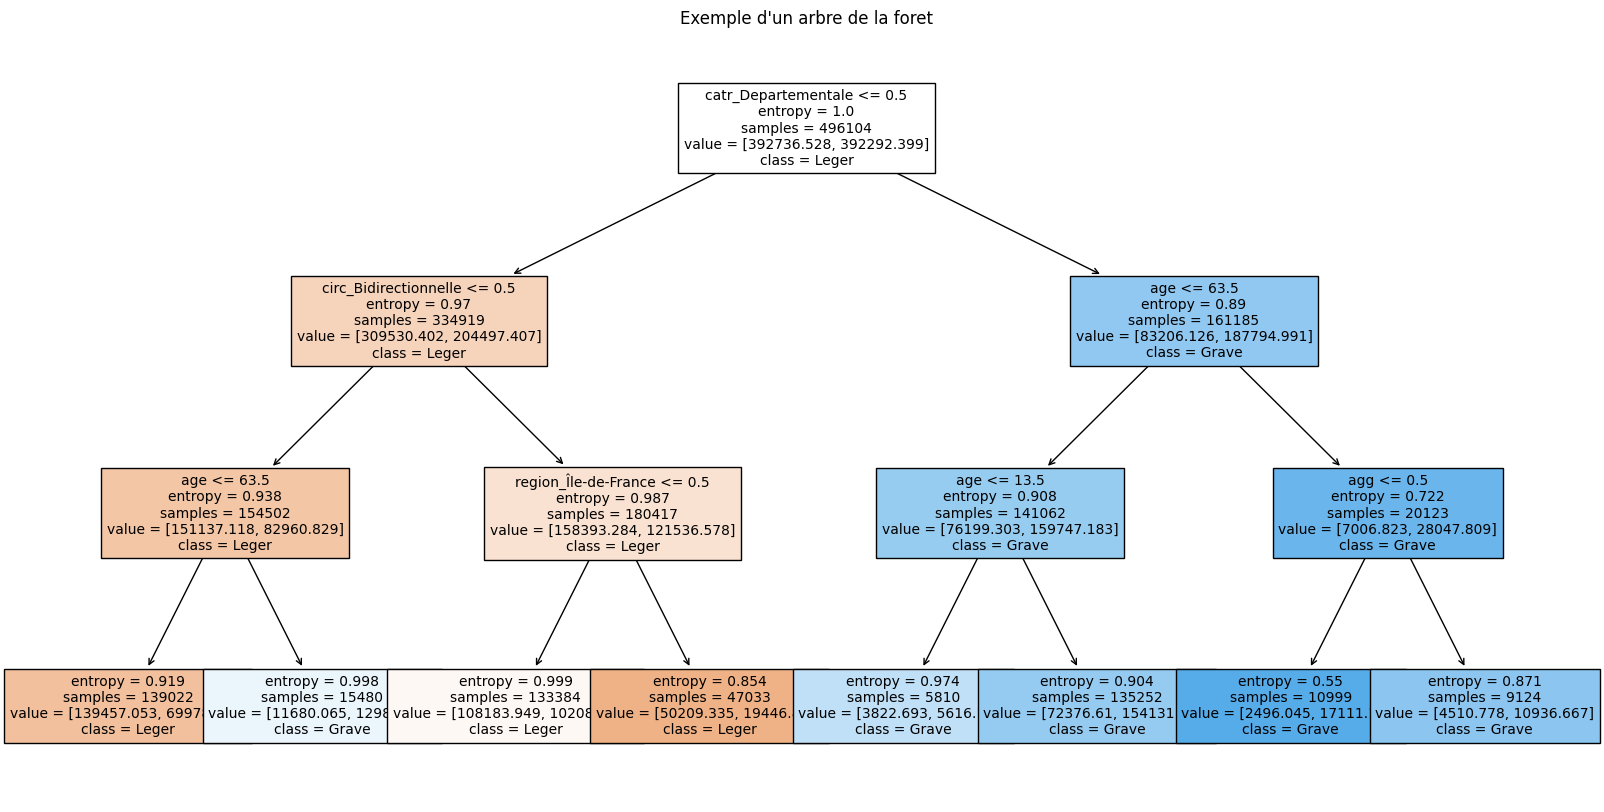

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], filled=True,max_depth=3,fontsize=10,feature_names=features,class_names=['Leger','Grave'])
plt.title("Exemple d'un arbre de la foret")
plt.show()


Calcul des valeurs de shap

In [ ]:
X_shap,_,y_shap,_=train_test_split(X_test,y_test,train_size=0.1)

explainer = shap.TreeExplainer(model)

_,shap_values = explainer.shap_values(X_shap)

print('Expected Value:', explainer.expected_value)

val=pd.DataFrame(shap_values)
# val

Expected Value: [0.50001745 0.49998255]


Plot des valeurs de SHAP

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


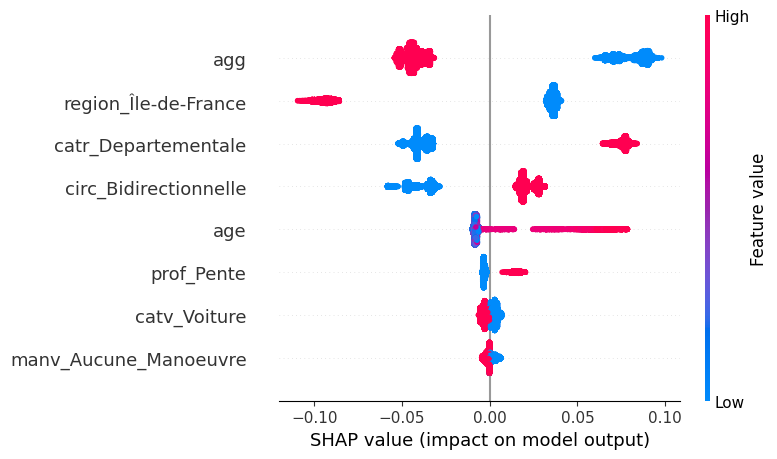

In [ ]:
shap.summary_plot(shap_values, X_shap,feature_names=features)

#DNN

In [ ]:
from tensorflow.keras.layers import Input, Dense #Pour instancier une couche Dense et une d'Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

In [ ]:
callbacks = [
    ModelCheckpoint("model_checkpoint.h5", save_best_only=True),
    EarlyStopping(patience=5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
]


inputs = Input(shape=98, name="Input")
dense1 = Dense(units=32, activation="relu", kernel_initializer='glorot_normal', name="Dense_1")
dropout_layer = Dropout(0.5) #dropout layer
dense2 = Dense(units=1, activation="sigmoid", kernel_initializer='glorot_normal', name="Dense_2")

dense1 = dense1(inputs)
dropout=dropout_layer(dense1) #dropout layer
outputs = dense2(dropout)

mod = Model(inputs=inputs, outputs=outputs)

def loss_Nico(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    vp =tf.reduce_sum(y_true*y_pred)
    totalp=tf.reduce_sum(y_true)
    recall=vp/(totalp + tf.keras.backend.epsilon())
    recall_loss=(1-recall)
    crossentropy=tf.keras.backend.binary_crossentropy(y_true,y_pred)
    loss = 0.5*recall_loss+crossentropy
    return loss


mod.compile(loss=loss_Nico,
              optimizer=tf.optimizers.Adam(learning_rate= 0.00001),
              metrics=["accuracy"])

DNN = mod.fit(np.asarray(X_ru).astype('int'), np.asarray(y_ru).astype('int'), epochs=20, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
16664/16664 [==============================] - 40s 2ms/step - loss: 0.9119 - accuracy: 0.5996 - val_loss: 0.8541 - val_accuracy: 0.6363 - lr: 1.0000e-05
Epoch 2/20
   86/16664 [..............................] - ETA: 29s - loss: 0.8448 - accuracy: 0.6610

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16664/16664 [==============================] - 41s 2ms/step - loss: 0.8276 - accuracy: 0.6734 - val_loss: 0.8052 - val_accuracy: 0.6609 - lr: 1.0000e-05
Epoch 3/20
16664/16664 [==============================] - 43s 3ms/step - loss: 0.8018 - accuracy: 0.6901 - val_loss: 0.7932 - val_accuracy: 0.6663 - lr: 1.0000e-05
Epoch 4/20
16664/16664 [==============================] - 43s 3ms/step - loss: 0.7907 - accuracy: 0.6986 - val_loss: 0.7826 - val_accuracy: 0.6714 - lr: 1.0000e-05
Epoch 5/20
16664/16664 [==============================] - 39s 2ms/step - loss: 0.7837 - accuracy: 0.7027 - val_loss: 0.7816 - val_accuracy: 0.6702 - lr: 1.0000e-05
Epoch 6/20
16664/16664 [==============================] - 38s 2ms/step - loss: 0.7793 - accuracy: 0.7065 - val_loss: 0.7753 - val_accuracy: 0.6719 - lr: 1.0000e-05
Epoch 7/20
16664/16664 [==============================] - 44s 3ms/step - loss: 0.7750 - accuracy: 0.7094 - val_loss: 0.7695 - val_accuracy: 0.6741 - lr: 1.0000e-05
Epoch 8/20
16664/16664 [===

In [ ]:
#Evaluation
y_pred = DNN.model.predict(np.asarray(X_test).astype('float64'))
y_pred_class = [0 if valeur < 0.5 else 1 for valeur in y_pred]

cm = pd.crosstab(y_test, y_pred_class, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(model,'\n')
print(cm,'\n')
report = classification_report(y_test, y_pred_class)
print(report,'\n')

10515/10515 [==============================] - 15s 1ms/step

Classe prédite       0      1
Classe réelle                
0               146729  46913
1                47453  95375 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76    193642
           1       0.67      0.67      0.67    142828

    accuracy                           0.72    336470
   macro avg       0.71      0.71      0.71    336470
weighted avg       0.72      0.72      0.72    336470
 



# Classification Multiclasse/Binaire - Analyse Factorielle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
!pip install factor_analyzer

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [ ]:
dataset_new = dataset.copy()

In [ ]:
dataset_new['grav'] = dataset_new['grav'].replace({1:"0",2:"3",3:"2",4:"1"}).astype(int)
dataset_new = dataset_new.sort_values(by='grav')
y = dataset_new['grav']
y_multiclass = np.array(y).ravel()
y_b =y.replace({0:'0',1:'0',2:'1',3:'1'}).astype(int)
y_binaire = np.array(y_b).ravel()
#target=target.apply(lambda x: 1 if (x==2 or x==3) else 0)
drop_var = ['grav','num_veh','date','Num_Acc', "age", "lum", "agg"]
X = dataset_new.drop(drop_var, axis=1)

# Sampling Adequacy - Kaiser-Meyer-Olkin (KMO) test

In [ ]:
#Sampling Adequacy - Kaiser-Meyer-Olkin (KMO) test

#Le test KMO mesure l’adéquation des données à l’analyse factorielle.
#Il détermine l'adéquation pour chaque variable observée et pour le modèle complet.
#KMO estime la proportion de variance entre toutes les variables observées. Une proportion plus faible convient mieux à l’analyse factorielle.
#Les valeurs de KMO varient entre 0 et 1. Une valeur de KMO inférieure à 0,6 est considérée comme insuffisante.


kmo_all, kmo_model = calculate_kmo(X)

print("Overall KMO = {:.3f}".format(kmo_model))
print("KMO per feature:\n{}".format(kmo_all.round(3)))

In [ ]:
# Variables jugées adéquates par le test KMO
kmo_passed = list(X.columns[kmo_all >= 0.5])
kmo_passed

In [ ]:
# Variables jugées inadéquates par le test KMO
kmo_failed = list(X.columns[kmo_all < 0.5])
kmo_failed

In [ ]:
print(len(kmo_passed))
print(len(kmo_failed))

In [ ]:
# Preuve pour confirmer que les variables choisis sont adéquate pour l'analyse factorielle
kmo_passed = list(X.columns[kmo_all >= 0.5])
X_kmo = X[kmo_passed]

kmo_all, kmo_model = calculate_kmo(X_kmo)

print("Overall KMO = {:.3f}".format(kmo_model))
print("KMO per feature:\n{}".format(kmo_all.round(3)))

In [ ]:
#Copier les variable choisit
X = X_kmo.copy()

In [ ]:
#Fonction pour entrainer le model
def train_factor_model(dataset, number_of_factors, rotation="varimax"):
  factor_model = FactorAnalyzer(n_factors=number_of_factors, rotation=rotation)
  factor_model.fit(dataset)

  return factor_model

In [ ]:
# Fonction pour representer les facteurs
def scree_plot(eigenvalues, n_columns):
  plt.style.use("fivethirtyeight")
  # Create scree plot using matplotlib
  fig, ax = plt.subplots(figsize=(10, 6))

  ax.scatter(range(1, n_columns + 1), eigenvalues, s=50)
  ax.plot(range(1, n_columns + 1), eigenvalues)

  ax.set_title('Scree Plot')
  ax.set_xlabel('# Factors')
  ax.set_ylabel('Eigenvalues')

  ax.grid(False)

  ax.axhline(y=1, linestyle="--", color="grey", linewidth=1)
  # plt.savefig("scree_plot.png", transparent=True, dpi=600)
  plt.show()

In [ ]:
def loadings_plot(loadings, variables):
  # Create loadings plot using matplotlib
  fig, ax = plt.subplots(figsize=(15, 5))

  image = ax.matshow(loadings, cmap="hot")

  n_factors = loadings.shape[1]
  factors = ["Factor{}".format(index) for index in range(n_factors)]

  ax.set_yticklabels([""] + variables, fontsize=10)
  ax.set_xticklabels([""] + factors, rotation="vertical", fontsize=10)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(False)

  plt.colorbar(image)
  plt.tight_layout()
  plt.show()

In [ ]:
factor_model = train_factor_model(X, len(X.columns), rotation="oblimin")

In [ ]:
# Choisir le nombre de facteurs
eigenvalues, common_factor_eigenvalues = factor_model.get_eigenvalues()
eigenvalues

In [ ]:
# Seuil = 1
n_columns = len(X.columns)
scree_plot(eigenvalues, n_columns=n_columns)

In [ ]:
number_of_factors = sum(eigenvalues > 1)
factor_model = train_factor_model(X, number_of_factors, rotation="promax")

In [ ]:
loadings = factor_model.loadings_
loadings_abs = np.abs(loadings)

columns = X.columns.tolist()
loadings_plot(loadings_abs, columns)

In [ ]:
#regrouper les facteurs
n_factors = loadings.shape[1]
factors_list = ["Factor{}".format(index) for index in range(n_factors)]
factors = {}.fromkeys(factors_list, None)
for key in factors:
  factors[key] = []

argsmax = loadings_abs.argmax(axis=1)
for argmax, column in zip(argsmax, columns):
  factors[factors_list[argmax]].append(column)

factors

Entraîner et évaluer un modèle multiclass avec les variables issue de l'analyse factorielle (latent)

In [ ]:
X_latent = factor_model.transform(X)
y_multiclass = np.array(y).ravel()

In [ ]:
# Fonction pour entraîner le modèle
def train(X, y, grid_params, seed):

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                      test_size=0.2,
                                                      random_state=seed,
                                                      stratify=y)

  # The models dict has same keys as grid_params
  # pointing to the grid search of each classifier
  models = {
      #"SGD": SGDClassifier(),
      "Logistic Regression": LogisticRegression()
      #"Random Forest": RandomForestClassifier(),
      #"AdaBoost": AdaBoostClassifier(),
      #"GradientBoost": GradientBoostingClassifier()
  }

  # store best estimators
  best_estimators = dict.fromkeys(models.keys())

  for model_name in models:
    base_clf = models[model_name]
    params = grid_params[model_name]

    print("[INFO] Performing Grid-Search CV ---- {}".format(model_name))
    model = GridSearchCV(base_clf, params, scoring='accuracy', cv=5, n_jobs=-1,
                         verbose=0)

    model.fit(X_train, y_train)
    best_estimators[model_name] = model.best_estimator_

  return best_estimators, X_test, y_test

In [ ]:
# Fonction pour évaluer le modèle
def evaluate_multiclass(models, X_test, y_test):
  results = pd.DataFrame(columns=["Overall Accuracy"], index=models.keys())

  for model_name, model in models.items():
    n_samples = len(y_test)
    y_pred = model.predict(X_test)

    overall_accuracy = np.sum(y_pred == y_test) / n_samples
    results.loc[model_name, :] = overall_accuracy

  return results

In [ ]:
# Fonction pour selectioner le meilleur modèle au cas ou l'on entraîne plusieurs modèles
def select_multiclass_model(models, X_test, y_test):
  best_overall_accuracy = -1
  best_model = ""
  n_samples = len(y_test)

  for model_name, model in models.items():
    y_pred = model.predict(X_test)

    overall_accuracy = np.sum(y_pred == y_test) / n_samples

    if overall_accuracy > best_overall_accuracy:
      best_overall_accuracy = overall_accuracy
      best_model = model_name

  print("{}\nOverall accuracy = {:.4f}".format(best_model, best_overall_accuracy))
  return models[best_model]

In [ ]:
grid_params_multiclass = {
   # "SGD": {
   #     "penalty": ["l1", "l2", "elasticnet"],
   #     "alpha": np.linspace(1e-5, 1e-3, 5),
   #     "learning_rate": ["optimal", "invscaling", "adaptive"],
   #     "eta0": np.linspace(1e-4, 1e-1, 5)
   # },
   "Logistic Regression": {
        "penalty": ["l1", "l2"],
        "C": [1, 2, 4, 5],
        "solver": ["liblinear"]
    }
    #"Random Forest": {
    #    "criterion": ["gini", "entropy"],
    #    "max_depth": np.linspace(3, 12, 4, dtype=np.int64),
    #    "min_samples_split": np.linspace(0.1, 0.5, 6),
    #    "min_samples_leaf": np.linspace(0.1, 0.5, 6),
    #    "max_features":["log2","sqrt"]
    #}
    #"AdaBoost": {
     #   "base_estimator": [DecisionTreeClassifier(max_depth=1),
     #                      DecisionTreeClassifier(max_depth=2),
      #                     DecisionTreeClassifier(max_depth=3)],
      #  "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
      #  "n_estimators": np.linspace(20, 80, 4, dtype=np.int64),
   # }
    #"GradientBoost": {
    #    "loss":["deviance"],
    #    "learning_rate": [0.01, 0.025, 0.05, 0.075],
    #    "min_samples_split": np.linspace(0.1, 0.5, 5),
    #    "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    #    "max_depth":[3, 5, 8],
    #    "max_features":["log2","sqrt"],
    #    "criterion": ["friedman_mse"],
    #   "subsample":[0.5, 0.618, 0.85],
    #    "n_estimators":[5, 10, 15]
   # }
}

In [ ]:
## Entraîner et évaluer un modèle multiclass avec les variables issue de l'analyse factorielle (latent)
seed = 42
estimators_multiclass_latent, X_test_latent, y_test_multiclass = train(X_latent, y_multiclass,
                                                                       grid_params_multiclass, seed)

evaluate_multiclass(estimators_multiclass_latent, X_test_latent, y_test_multiclass)

In [ ]:
def classification_repot(models, X_test, y_test):
  best_overall_accuracy = -1
  best_model = ""
  n_samples = len(y_test)

  for model_name, model in models.items():
    y_pred = model.predict(X_test)
    C = classification_report(y_test, y_pred)
    overall_accuracy = np.sum(y_pred == y_test) / n_samples

    if overall_accuracy > best_overall_accuracy:
      best_overall_accuracy = overall_accuracy
      best_model = model_name

  #print("{}\nOverall accuracy = {:.4f}".format(best_model, best_overall_accuracy))
  return print(C)

classifition = classification_repot(estimators_multiclass_latent, X_test_latent, y_test_multiclass)

In [ ]:
## Entraîner et évaluer un modèle multiclass avec les variables d'origine (sans analyse factorielle)
seed = 42
estimatorsmulticlass, X_test, y_test_multiclass = train(X, y_multiclass,
                                                         grid_params_multiclass,
                                                         seed)

evaluate_multiclass(estimators_multiclass, X_test, y_test_multiclass)

In [ ]:
def classification_repot(models, X_test, y_test):
  best_overall_accuracy = -1
  best_model = ""
  n_samples = len(y_test)

  for model_name, model in models.items():
    y_pred = model.predict(X_test)
    C = classification_report(y_test, y_pred)
    overall_accuracy = np.sum(y_pred == y_test) / n_samples

    if overall_accuracy > best_overall_accuracy:
      best_overall_accuracy = overall_accuracy
      best_model = model_name

  #print("{}\nOverall accuracy = {:.4f}".format(best_model, best_overall_accuracy))
  return print(C)

classifition = classification_repot(estimators_multiclass, X_test, y_test_multiclass)

# Binaire classification - Analyse factorielle

In [ ]:
def evaluate_binary(models, X_test, y_test):

  results = pd.DataFrame(columns=["accuracy", "Precision", "Recall", "F1 Score"],
                         index=models.keys())

  for model_name, model in models.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.loc[model_name, :] = accuracy, precision, recall, f1

  return results

In [ ]:
# choose best models based on accuracy
def select_binary_model(models, X_test, y_test):
  best_accuracy = -1
  best_model = ""
  for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model_name

  print("{}\naccuracy = {:.4f}".format(best_model, best_accuracy))
  return models[best_model]

In [ ]:
grid_params_binary = {
   # "SGD": {
   #     "penalty": ["l1", "l2", "elasticnet"],
   #     "alpha": np.linspace(1e-5, 1e-3, 5),
   #     "learning_rate": ["optimal", "invscaling", "adaptive"],
   #     "eta0": np.linspace(1e-4, 1e-1, 5)
   # },
    "Logistic Regression": {
        "penalty": ["l1", "l2"],
        "C": [1, 2, 4, 5],
        "solver": ["liblinear"]
    }
   # "Random Forest": {
   #     "criterion": ["gini", "entropy"],
   #     "max_depth": np.linspace(3, 12, 4, dtype=np.int64),
   #     "min_samples_split": np.linspace(0.1, 0.5, 6),
   #     "min_samples_leaf": np.linspace(0.1, 0.5, 6),
   #     "max_features":["log2","sqrt"]
   # },
   # "AdaBoost": {
   #     "base_estimator": [DecisionTreeClassifier(max_depth=1),
   #                        DecisionTreeClassifier(max_depth=2),
   #                        DecisionTreeClassifier(max_depth=3)],
   #     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
   #     "n_estimators": np.linspace(20, 80, 4, dtype=np.int64),
   # },
   # "GradientBoost": {
   #     "loss":["deviance"],
   #     "learning_rate": [0.01, 0.025, 0.05, 0.075],
   #     "min_samples_split": np.linspace(0.1, 0.5, 5),
   #     "min_samples_leaf": np.linspace(0.1, 0.5, 5),
   #     "max_depth":[3, 5, 8],
   #     "max_features":["log2","sqrt"],
   #     "criterion": ["friedman_mse"],
   #     "subsample":[0.5, 0.618, 0.85],
   #     "n_estimators":[5, 10, 15]
   # }
}

In [ ]:
# Entraîner et évaluer un modèle binaire avec des variables d'analyse factorielle (latent)
estimators_binary_latent, X_test_latent, y_test_binary = train(X_latent,
                                                               y_binary,
                                                               grid_params_binary,
                                                               seed)

evaluate_binary(estimators_binary_latent, X_test_latent, y_test_binary)

In [ ]:
# Entraîner et évaluer un modèle binaire avec les variables d'origine (sans analyse factorielle)
estimators_binary, X_test, y_test_binary = train(X, y_binary,
                                                 grid_params_binary,
                                                 seed)

evaluate_binary(estimators_binary, X_test, y_test_binary)

# Comparaison des models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,stratify=target,random_state=723)

In [ ]:
FINAL_models[0].score(X_test,y_test)